In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from dviforbml.utils.helper import download_run_dvi
from collections import defaultdict
import os

In [2]:
project = "cluster-dvi-new"

num_steps = [16]
self_attn_num_heads = [None, 4]
max_context_size = [None, 10]
context_variant = ["mean", "bca"]
noise_variant = ["free", "constr"]
model_variant = ["dis", "dis_score", "cmcd", "ula"]
contextual_schedules = [True, False]

group_ids = [
    "Number of Diffusion Steps",
    "With Self-Attention",
    "With Context Size Embedding",
    "Context Variant",
    "Noise Schedule Variant",
    "DVI Variant",
    "With Contextual Schedules",
]

names = [
    "-".join(map(str, values))
    for values in product(
        num_steps,
        self_attn_num_heads,
        max_context_size,
        context_variant,
        noise_variant,
        model_variant,
        contextual_schedules,
    )
]

names.remove("16-None-10-bca-constr-cmcd-True")
names.remove("16-4-None-bca-constr-ula-True")
# print(names)

In [3]:
# from tqdm import tqdm

# for name in tqdm(names):
#     download_run_dvi(project, name)

In [4]:
def group_names_by_index(names, index):
    grouped = defaultdict(list)
    for name in names:
        parts = name.split("-")
        if index < len(parts):
            key = parts[index]
            grouped[key].append(name)
    return dict(grouped)

In [5]:
import math


def average_group_data(grouped_names):
    averaged_data = {}

    for group_value, name_list in grouped_names.items():
        data_frames = []

        for name in name_list:
            file_path = f"../models/{project}/{name}/metrics.csv"
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df = df.rename(columns={df.columns[0]: "index"})
                data_frames.append(df)
            else:
                print(f"Missing file: {file_path}")

        if data_frames:
            # Merge and average by 'index'
            all_df = pd.concat(data_frames)
            avg_df = all_df.groupby("index").mean().reset_index()
            averaged_data[group_value] = avg_df

    return averaged_data


def plot_group_averages(averaged_data, i, value_column="jsds"):
    plt.figure(figsize=(4, 2))
    for group_name, df in averaged_data.items():
        plt.plot(df["index"], df[value_column], label=group_name, marker="o")

    plt.xlabel("Context Size")
    plt.ylabel("Average JSD")
    plt.title(f"{group_ids[i]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"{group_ids[i]}.pdf")
    plt.show()

Missing file: ../models/cluster-dvi-new/16-4-10-mean-free-ula-False/metrics.csv
None
4
Missing file: ../models/cluster-dvi-new/16-4-10-mean-free-ula-False/metrics.csv
Missing file: ../models/cluster-dvi-new/16-4-10-mean-free-ula-False/metrics.csv
Missing file: ../models/cluster-dvi-new/16-4-10-mean-free-ula-False/metrics.csv
Missing file: ../models/cluster-dvi-new/16-4-10-mean-free-ula-False/metrics.csv
Missing file: ../models/cluster-dvi-new/16-4-10-mean-free-ula-False/metrics.csv


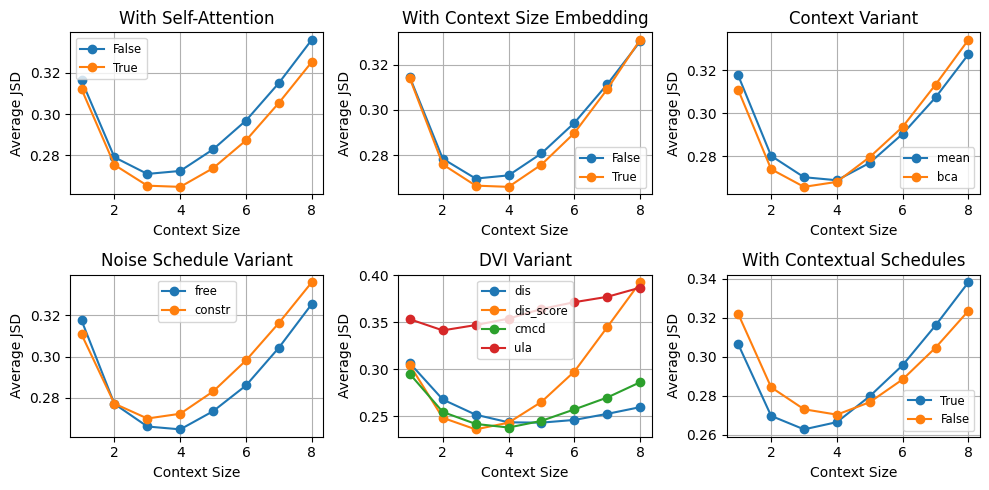

In [ ]:
fig, axes = plt.subplots(
    2, 3, figsize=(10, 5)
)  # 6 plots total (since we're skipping one)
axes = axes.flatten()

plot_indices = [i for i in range(7) if i != 0]  # exclude index 0

for ax, i in zip(axes, plot_indices):
    grouped = group_names_by_index(names, i)
    average_data = average_group_data(grouped)

    for group_name, df in average_data.items():
        if i == 1:
            print(group_name)
            if group_name == "4":
                label = "True"
            else:
                label = "False"
        elif i == 2:
            if group_name == "10":
                label = "True"
            else:
                label = "False"
        else:
            label = group_name

        ax.plot(df["index"], df["jsds"], label=label, marker="o")

    ax.set_title(group_ids[i])
    ax.set_xlabel("Context Size")
    ax.set_ylabel("Average JSD")
    ax.grid(True)
    ax.legend(fontsize="small")

plt.tight_layout()
plt.savefig("grouped_averages_grid_no_index0.pdf")
plt.show()

In [ ]:
# for i in range(7):
#     grouped = group_names_by_index(names, i)
#     average_data = average_group_data(grouped)
#     plot_group_averages(average_data, i)

In [14]:
def get_avg_jsd_per_name(names):
    avg_jsd_map = {}

    for name in names:
        file_path = f"../models/{project}/{name}/metrics.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df = df.rename(columns={df.columns[0]: "index"})
            avg_jsd = df["jsds"].mean()
            avg_jsd_map[name] = avg_jsd
        else:
            print(f"Missing file: {file_path}")

    return avg_jsd_map


def plot_top_n_jsd(names, top_n=4):
    avg_jsd_map = get_avg_jsd_per_name(names)

    # Sort names by average jsd
    top_names = sorted(avg_jsd_map, key=avg_jsd_map.get)[:top_n]

    plt.figure(figsize=(6, 4))
    for name in top_names:
        file_path = f"../models/{project}/{name}/metrics.csv"
        df = pd.read_csv(file_path)
        df = df.rename(columns={df.columns[0]: "index"})
        plt.plot(
            df["index"],
            df["jsds"],
            marker="o",
            label=f"{name} (avg={avg_jsd_map[name]:.3f})",
        )

    plt.xlabel("Context Size Index")
    plt.ylabel("JSD")
    plt.title(f"Top {top_n} Models with Best Average JSD")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("top3.pdf")
    plt.show()

Missing file: ../models/cluster-dvi-new/16-4-10-mean-free-ula-False/metrics.csv


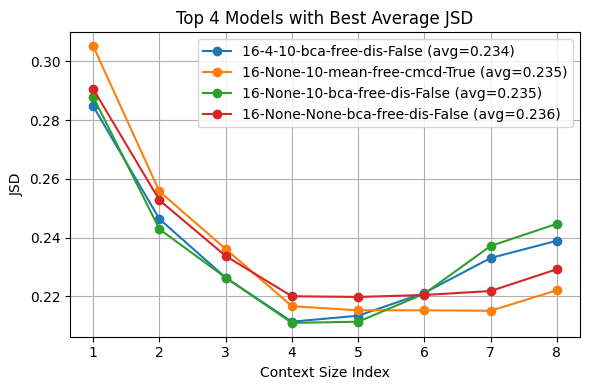

In [15]:
plot_top_n_jsd(names)

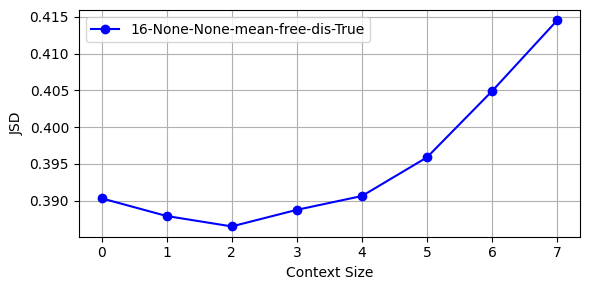

In [10]:
name = names[0]

figure = plt.figure(figsize=(6, 3))

df = pd.read_csv(f"../models/{project}/{name}/metrics.csv")
df.head

plt.plot(df.index, df["jsds"], marker="o", label=name, color="blue")

plt.xlabel("Context Size")
plt.ylabel("JSD")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()